In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from sklearn.decomposition import PCA

current_directory = os.getcwd()
cifar_directory = os.path.join(current_directory,"../CIFAR-10")


C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Defining model architecture
To apply resnet18 to MNIST data we need to define our model architecture using pytorch. This task has been done by dozens of computer scientists before so finding pre-existing implementations of the architecture was quite easy. In fact, resnet18 is so popular for these tasks that there was an option to import the model altogether without redefining the model architecture but recreating it allows for opportunities for modification later and better interpretability of what the CNN is doing. 

Residual networks create a block for the input data and pass the original block of data combined with output from the previous layer into the next layer. This prevents loss of data integrity and vanishing gradients as the input gets propagated deeper into the network.

<p align="center"><img src="images/resnet18ex1.png" alt="Diagram showing the skip block" width="75%"/> </br> This diagram shows the original block "skipping" a layer and being passed as input into the next layer </p>
<p align="center"><img src="images/resnet18ex2.png" alt="Diagram showing the layers of Resnet18" width="75%"/></br> This diagram visualizes the internal layers specifications</p>

We can see the intricacies of each layer. The data is first convoluted into a block which is passed to other layers. Resnet has 8 layers of convolutional filters before being pooled. In this example, the output is softmaxed but for our purposes we modify it to use a linear output to predict one of the 10 classes. 

In [3]:
# Architecture Sourced From: https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb
# Resnet Paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
# https://www.researchgate.net/figure/ResNet-18-architecture-20-The-numbers-added-to-the-end-of-ResNet-represent-the_fig2_349241995

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

# Define the BasicBlock
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes * self.expansion, stride)  # Adjusted out_channels here
        self.bn1 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes * self.expansion, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


# Define the ResNet model
class ResNetCIFAR(nn.Module):
    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNetCIFAR, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [4]:
# Create the ResNet18 model
NUM_CLASSES = 10  # Number of classes in MNIST
GRAYSCALE = False
resnet18_model = ResNetCIFAR(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
resnet18_model.to(device)

ResNetCIFAR(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

### Loading the Data
CIFAR10 is saved in batches of bytecode and needs to be reassembled. The bytecode is opened using pickle and then appended into a numpy array. Unfortunately, the neural network architecture we have does not use one-hot encoding vectors (due to being a CNN and not a vanilla NN) so the data must be unflattened into a pytorch image format with the shape (# records, # channels, width, height). 

The data is then converted to a tensor dataset and loaded for pytorch. To speed up computation we push the tensors to a GPU if available.

In [5]:
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# Helper function which concatenate the data from the 5 files into one large file
def load_cifar10_data(data_dir):
    train_batches = []
    for i in range(1, 6):
        file_path = f"{data_dir}/data_batch_{i}"
        train_batches.append(load_cifar10_batch(file_path))

    test_batch = load_cifar10_batch(f"{data_dir}/test_batch")

    # Concatenate training batches to get the full training dataset
    train_data = np.concatenate([batch[b'data'] for batch in train_batches])
    # Data Normalization
    train_data = train_data
    print(train_data)
    train_labels = np.concatenate([batch[b'labels'] for batch in train_batches])

    # Extract test data and labels
    test_data = test_batch[b'data']
    # Data Normalization
    test_data = test_data 
    print(test_data)
    test_labels = test_batch[b'labels']

    return train_data, train_labels, test_data, test_labels

def convert_to_pytorch_images(data_array):
    """
    Convert a single record into a pytorch image. Pytorch takes in a very specific input where each record is 3x32x32.

    Parameters:
    - One-hot vector the first 1024 values represent the red channel of pixels, the second 1024 values represent the green channel of pixels, and the last 1024 values represent the blue channel of pixels

    Returns: 
    - a numpy array representing the image data in pytorch format
    """

    num_images = data_array.shape[0]
    image_size = 32

    # Split the array into three parts
    split_size = data_array.shape[1] // 3
    red_channel = data_array[:, :split_size].reshape((num_images, 1, image_size, image_size))
    green_channel = data_array[:, split_size:2*split_size].reshape((num_images, 1, image_size, image_size))
    blue_channel = data_array[:, 2*split_size:].reshape((num_images, 1, image_size, image_size))

    # Stack the channels along the second axis to get the final shape (num_images, 3, 32, 32)
    return np.concatenate([red_channel, green_channel, blue_channel], axis=1)
    

    
def grayscale(data_array):
    """
    Convert a single record into a greyscaled pytorch image. Pytorch takes in a very specific input where each record is 3x32x32.

    Parameters:
    - One-hot vector the first 1024 values represent the red channel of pixels, the second 1024 values represent the green channel of pixels, and the last 1024 values represent the blue channel of pixels

    Returns: 
    - a numpy array representing the image data in pytorch format
    """
    num_images = data_array.shape[0]
    image_size = 32

    # Split the array into three parts
    split_size = data_array.shape[1] // 3
    red_channel = data_array[:, :split_size].reshape((num_images, 1, image_size, image_size))
    green_channel = data_array[:, split_size:2*split_size].reshape((num_images, 1, image_size, image_size))
    blue_channel = data_array[:, 2*split_size:].reshape((num_images, 1, image_size, image_size))

    # Greyscale the data by aggregating rgb values. The greyscale formula is pre-existing 
    grayscale_data = 0.299 * red_channel + 0.587 * green_channel + 0.114 * blue_channel

    # Reshape to PyTorch format: (num_images, 1, 32, 32)
    grayscale_data = grayscale_data.reshape((num_images, 1, image_size, image_size))

    return grayscale_data

In [6]:
# Load the data from CSVs using pandas
train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar_directory)

# Append the labels
columns = [f"pixel_{i+1}" for i in range(train_data.shape[1])]
cifar_train = pd.DataFrame(train_data, columns=columns)
cifar_train['label'] = train_labels

cifar_test = pd.DataFrame(test_data, columns=columns)
cifar_test['label'] = test_labels

# Extract labels and pixel values
train_labels = cifar_train.iloc[:, -1].values
train_images = cifar_train.iloc[:, :-1].values / 255.0

test_labels = cifar_test.iloc[:, -1].values
test_images = cifar_test.iloc[:, :-1].values / 255.0

train_images = convert_to_pytorch_images(train_images)
test_images = convert_to_pytorch_images(test_images)
if GRAYSCALE:
    train_images = grayscale(train_images)
    test_images = grayscale(test_images)
print(train_images.shape)
print(test_images.shape)

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 35  40  42 ...  77  66  50]
 [189 186 185 ... 169 171 171]
 [229 236 234 ... 173 162 161]]
[[158 159 165 ... 124 129 110]
 [235 231 232 ... 178 191 199]
 [158 158 139 ...   8   3   7]
 ...
 [ 20  19  15 ...  50  53  47]
 [ 25  15  23 ...  80  81  80]
 [ 73  98  99 ...  94  58  26]]
(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [7]:
# Reshape the images to [batch_size, 1, 32, 32]

if GRAYSCALE:
    train_images_tensor = train_images_tensor.view(-1, 1, 32, 32)
    test_images_tensor = test_images_tensor.view(-1, 1, 32, 32)
else:
    train_images_tensor = train_images_tensor.view(-1, 3, 32, 32)
    test_images_tensor = test_images_tensor.view(-1, 3, 32, 32)



# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# # Download CIFAR-10 dataset and apply transformations
# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=8, shuffle=False)
# Move the data to the GPU

train_images_tensor, train_labels_tensor = train_images_tensor.to(device), train_labels_tensor.to(device)
test_images_tensor, test_labels_tensor = test_images_tensor.to(device), test_labels_tensor.to(device)


### Training the Model
Training the model is straightforward: the resnet18 model is initialized with the learning rate and cross entropy loss function hyperparameters, and then training is run for a certain number of epochs by passing in image data into the neural network.

In [8]:
criterion = nn.CrossEntropyLoss()

# Choi, D., Shallue, C. J., Nado, Z., Lee, J., Maddison, C. J., & Dahl, G. E. (2019). On empirical comparisons of optimizers for deep learning. arXiv preprint arXiv:1910.05446.
# optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001,weight_decay=1e-4)
optimizer = optim.Adam(resnet18_model.parameters(), lr=1e-3)
# optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01,weight_decay=1e-4, momentum=0.95)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed
# Gradient Clipping led to underfitting on CIFAR10
# max_grad_norm = 5.0

# Compute Train Accuracy
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for _, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        _, class_probabilities = model(features)
        _, predicted_labels = torch.max(class_probabilities, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum().item()
    return correct_pred / num_examples * 100

# While training run nvidia-smi in the terminal to check gpu tasks 
train_accuracies = []
train_losses = []

# Training the model
num_epochs = 20
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    epoch_losses = []

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Move data to the GPU
        images, labels = images.to(device), labels.to(device)
        outputs, _ = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        
        # clip_grad_norm_(resnet18_model.parameters(), max_grad_norm)

        optimizer.step()

        train_losses.append(loss.item())
        

        # Calculate training accuracy
        current_lr = optimizer.param_groups[0]['lr']
        # current_lr = 0.01

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Learning Rate: {current_lr:.6f}')
    scheduler.step()
    
    training_accuracy = compute_accuracy(resnet18_model, train_loader, device)
    train_accuracies.append(training_accuracy)

    # epoch_loss_avg = sum(epoch_losses) / len(epoch_losses)
    
    # train_losses.append(epoch_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {training_accuracy:.4f}')
    
print('Training finished.')

Epoch [1/20], Step [100/196], Loss: 1.3583, Learning Rate: 0.001000
Epoch [1/20], Training Accuracy: 60.8660
Epoch [2/20], Step [100/196], Loss: 1.0410, Learning Rate: 0.001000
Epoch [2/20], Training Accuracy: 70.9000
Epoch [3/20], Step [100/196], Loss: 0.7891, Learning Rate: 0.001000
Epoch [3/20], Training Accuracy: 76.5760
Epoch [4/20], Step [100/196], Loss: 0.6765, Learning Rate: 0.001000
Epoch [4/20], Training Accuracy: 80.0960
Epoch [5/20], Step [100/196], Loss: 0.5554, Learning Rate: 0.001000
Epoch [5/20], Training Accuracy: 83.6260
Epoch [6/20], Step [100/196], Loss: 0.3432, Learning Rate: 0.000500
Epoch [6/20], Training Accuracy: 92.2660
Epoch [7/20], Step [100/196], Loss: 0.2199, Learning Rate: 0.000500
Epoch [7/20], Training Accuracy: 93.9920
Epoch [8/20], Step [100/196], Loss: 0.2037, Learning Rate: 0.000500
Epoch [8/20], Training Accuracy: 95.3580
Epoch [9/20], Step [100/196], Loss: 0.1132, Learning Rate: 0.000500
Epoch [9/20], Training Accuracy: 96.8680
Epoch [10/20], Step

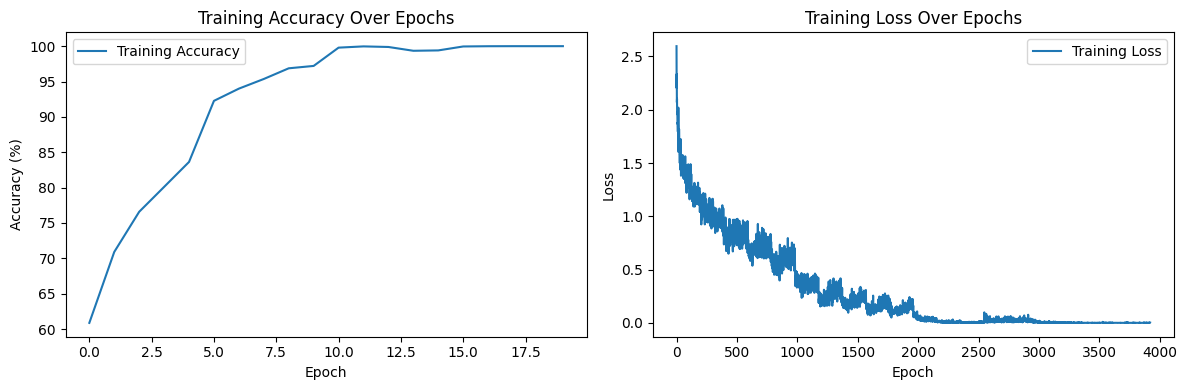

In [9]:
# Plotting training accuracies and losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(resnet18_model.state_dict(), 'resnet18_cifar_model.pth')

### Testing the Model
Using the test tensor we initialized above, we can set the model into evaluation mode and then record how accurate it is at making predictions. CIFAR10 in the resnet18 model achieved ~75% accuracy

In [11]:
# Move the test data to the GPU
test_images_tensor, test_labels_tensor = test_images_tensor.to(device), test_labels_tensor.to(device)

# # Create TensorDataset and DataLoader for the test data
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test data
resnet18_model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        print(images.shape)
        outputs, _ = resnet18_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])
torch.Size([25